In [12]:
# --- Imports and Configuration ---
import pandas as pd
import numpy as np
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
print("--- Running in CPU-only mode ---")

--- Running in CPU-only mode ---


## EDA

In [21]:
sns.set_style("whitegrid")

df = pd.read_csv('promise19_dataset.csv')

print("--- Dataset Info ---")
df.info()

print("\n--- Dataset Head ---")
display(df.head())

print("\n--- Numerical Features Statistics ---")
display(df.describe())

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73293 entries, 0 to 73292
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Project                    73293 non-null  object 
 1   Owner                      73293 non-null  object 
 2   Manager                    73293 non-null  object 
 3   Category                   73293 non-null  object 
 4   Key                        73293 non-null  object 
 5   Priority                   73292 non-null  object 
 6   Status                     73293 non-null  object 
 7   Reporter                   73271 non-null  object 
 8   Assignee                   65176 non-null  object 
 9   Components                 46592 non-null  object 
 10  SummaryTopWords            72633 non-null  object 
 11  DescriptionTopWords        68968 non-null  object 
 12  CommentsTopWords           70286 non-null  object 
 13  CreationDate             

,Project,Owner,Manager,Category,Key,Priority,Status,Reporter,Assignee,Components,...,SrcAddLines,SrcDelLines,TestAddFiles,TestDelFiles,TestModFiles,TestAddLines,TestDelLines,LoC,FirstCommitDate,LastCommitDate
0,Buildr,ASF,Apache Buildr Committee,build-management,BUILDR-235,Trivial,Closed,alexismidon,NaN,JRuby Site/documentation,...,0,0,0,0,0,0,0,932.0,2009-03-12 23:35:27,2009-03-12 23:35:27
1,Buildr,ASF,Apache Buildr Committee,build-management,BUILDR-236,Major,Closed,alexismidon,NaN,NaN,...,0,0,0,0,0,0,0,0.0,NaN,NaN
2,Buildr,ASF,Apache Buildr Committee,build-management,BUILDR-239,Major,Closed,jmuzz,NaN,Core features,...,27,1,0,0,0,0,0,1678.0,2009-03-12 23:42:37,2009-03-12 23:42:37
3,Buildr,ASF,Apache Buildr Committee,build-management,BUILDR-241,Major,Closed,rsutphin,NaN,IDE,...,153,2,0,0,0,0,0,1165.0,2009-03-12 23:47:00,2009-03-13 02:50:15
4,Buildr,ASF,Apache Buildr Committee,build-management,BUILDR-243,Minor,Closed,digitalsanctum,NaN,Compilers,...,0,0,0,0,0,0,0,0.0,NaN,NaN



--- Numerical Features Statistics ---


,NoComments,NoWatchers,NoAttachments,NoAttachedPatches,HasMergeCommit,NoCommits,NoAuthors,NoCommitters,NonSrcAddFiles,NonSrcDelFiles,...,SrcDelFiles,SrcModFiles,SrcAddLines,SrcDelLines,TestAddFiles,TestDelFiles,TestModFiles,TestAddLines,TestDelLines,LoC
count,73293.000000,73293.0,73293.000000,73293.000000,73293.00000,73293.000000,73293.000000,73293.000000,73293.000000,73293.000000,...,73293.000000,73293.000000,73293.000000,7.329300e+04,73293.000000,73293.000000,73293.000000,73293.000000,73293.000000,7.329300e+04
mean,8.640143,0.0,1.344371,1.058491,0.02067,1.078111,0.877833,0.873562,0.311967,0.061930,...,0.134897,3.418676,120.708185,9.424169e+01,0.206145,0.064385,1.371072,49.631848,24.792463,1.993661e+03
std,10.290377,0.0,2.133116,1.869991,0.14228,1.345217,0.476686,0.471205,7.158014,4.138886,...,9.929987,40.673013,4204.143321,6.168428e+03,7.932170,7.603322,32.734185,1648.127612,1622.947729,1.372696e+04
min,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.000000,0.0,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,5.000000,0.0,1.000000,0.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,6.000000,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,11.000000,0.0,2.000000,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,2.000000,28.000000,1.000000e+01,0.000000,0.000000,1.000000,13.000000,0.000000,1.104000e+03
max,232.000000,0.0,70.000000,38.000000,1.00000,98.000000,6.000000,6.000000,591.000000,828.000000,...,1716.000000,6086.000000,743938.000000,1.484513e+06,1475.000000,1451.000000,6381.000000,291020.000000,289116.000000,1.048484e+06


C:\Users\Coral\AppData\Local\Temp\ipykernel_8500\2051265735.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Priority', data=df, order=priority_order, palette='viridis')


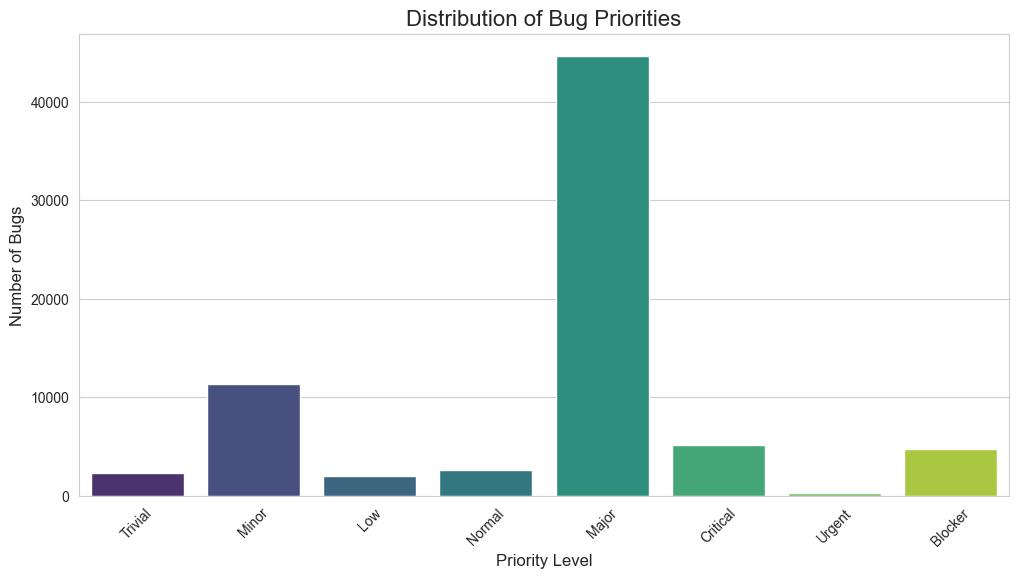


--- Bug Priority Counts ---
Priority
Major       44638
Minor       11376
Critical     5159
Blocker      4771
Normal       2637
Trivial      2347
Low          2076
Urgent        288
Name: count, dtype: int64


In [22]:
priority_order = ['Trivial', 'Minor', 'Low', 'Normal', 'Major', 'Critical', 'Urgent', 'Blocker']

plt.figure(figsize=(12, 6))
sns.countplot(x='Priority', data=df, order=priority_order, palette='viridis')

plt.title('Distribution of Bug Priorities', fontsize=16)
plt.ylabel('Number of Bugs', fontsize=12)
plt.xlabel('Priority Level', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print("\n--- Bug Priority Counts ---")
print(df['Priority'].value_counts())

C:\Users\Coral\AppData\Local\Temp\ipykernel_8500\401288628.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Priority', y=feature, data=df, order=priority_order, palette='coolwarm')


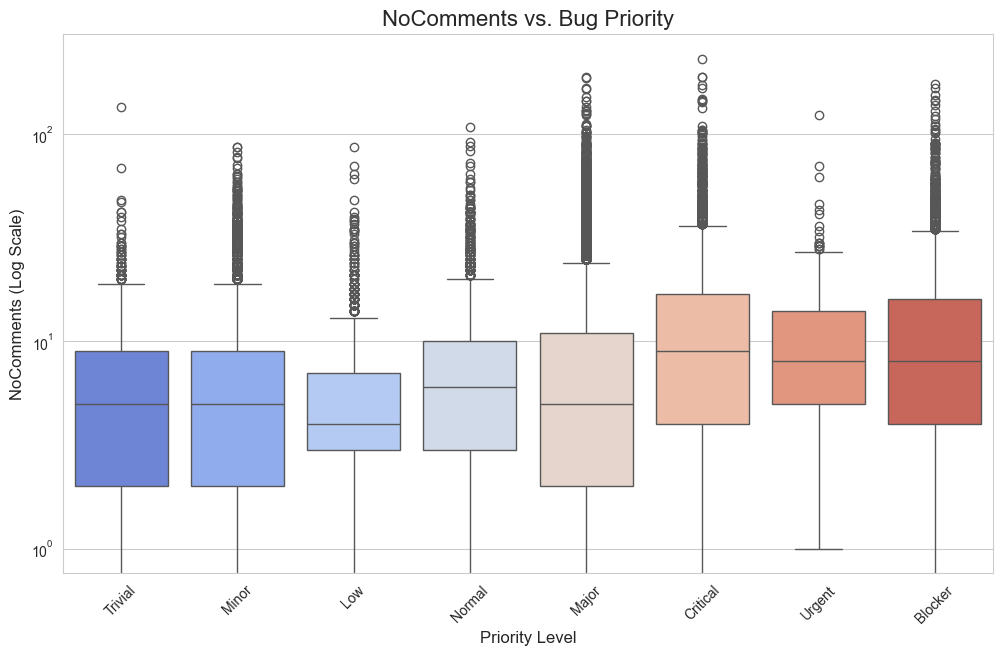

C:\Users\Coral\AppData\Local\Temp\ipykernel_8500\401288628.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Priority', y=feature, data=df, order=priority_order, palette='coolwarm')
C:\Users\Coral\AppData\Local\Temp\ipykernel_8500\401288628.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


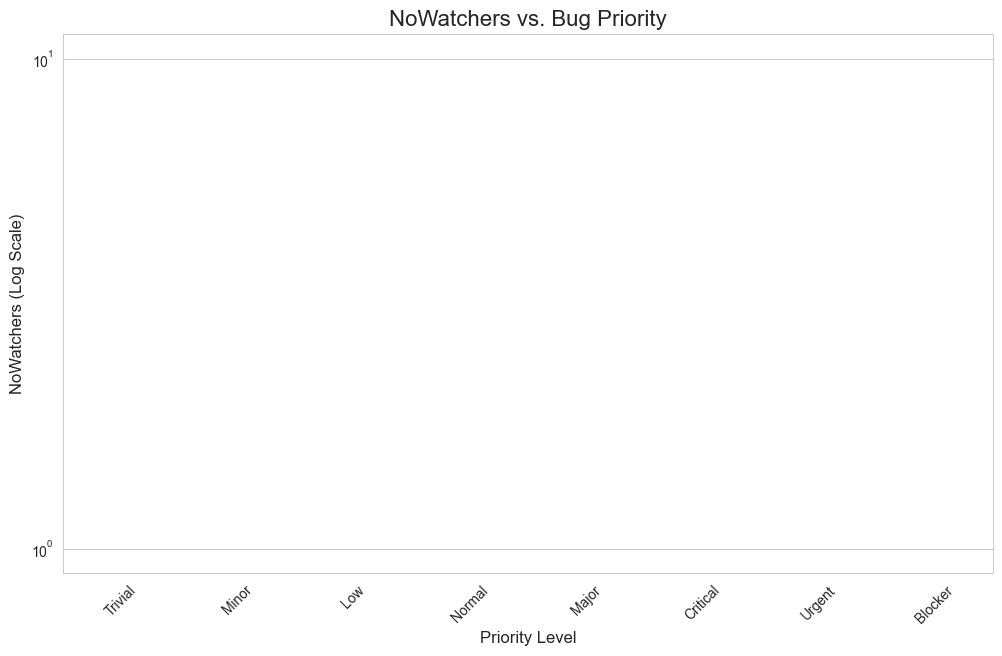

C:\Users\Coral\AppData\Local\Temp\ipykernel_8500\401288628.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Priority', y=feature, data=df, order=priority_order, palette='coolwarm')


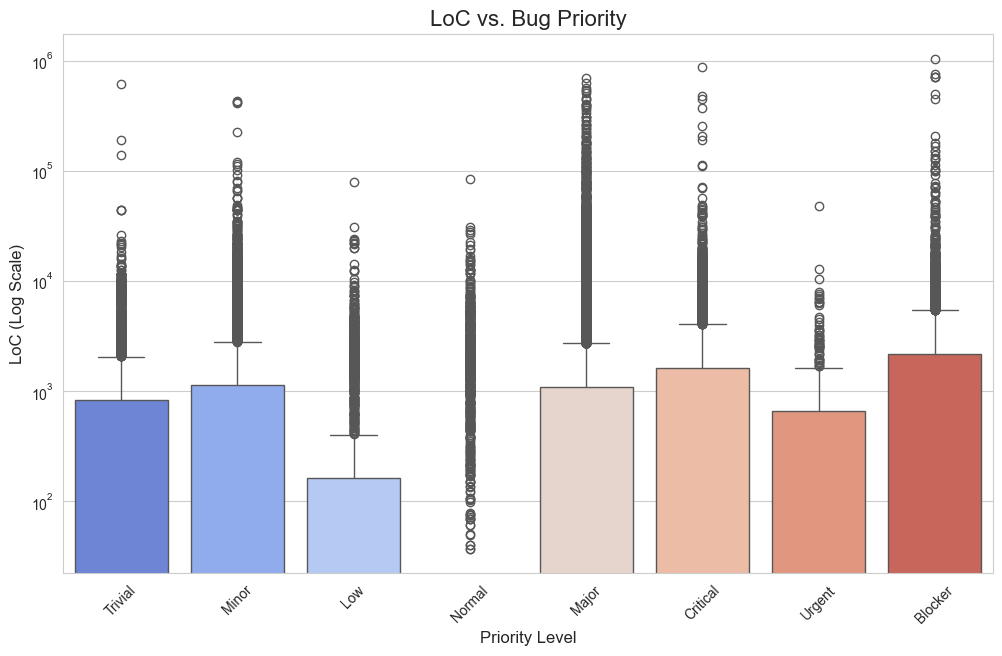

C:\Users\Coral\AppData\Local\Temp\ipykernel_8500\401288628.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Priority', y=feature, data=df, order=priority_order, palette='coolwarm')


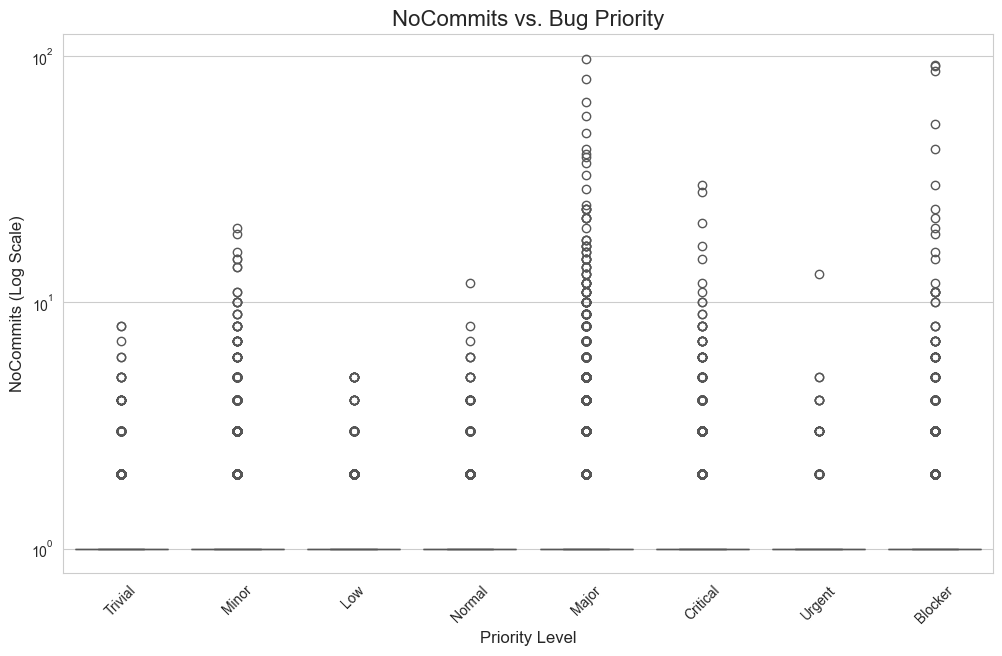

In [23]:
numerical_features = ['NoComments', 'NoWatchers', 'LoC', 'NoCommits']

for feature in numerical_features:
    plt.figure(figsize=(12, 7))
    # We use a log scale on the y-axis to better visualize skewed data
    sns.boxplot(x='Priority', y=feature, data=df, order=priority_order, palette='coolwarm')
    plt.yscale('log')
    plt.title(f'{feature} vs. Bug Priority', fontsize=16)
    plt.ylabel(f'{feature} (Log Scale)', fontsize=12)
    plt.xlabel('Priority Level', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

C:\Users\Coral\AppData\Local\Temp\ipykernel_8500\3750888237.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Priority', y='BugLifetime_days', data=df, order=priority_order, palette='plasma')


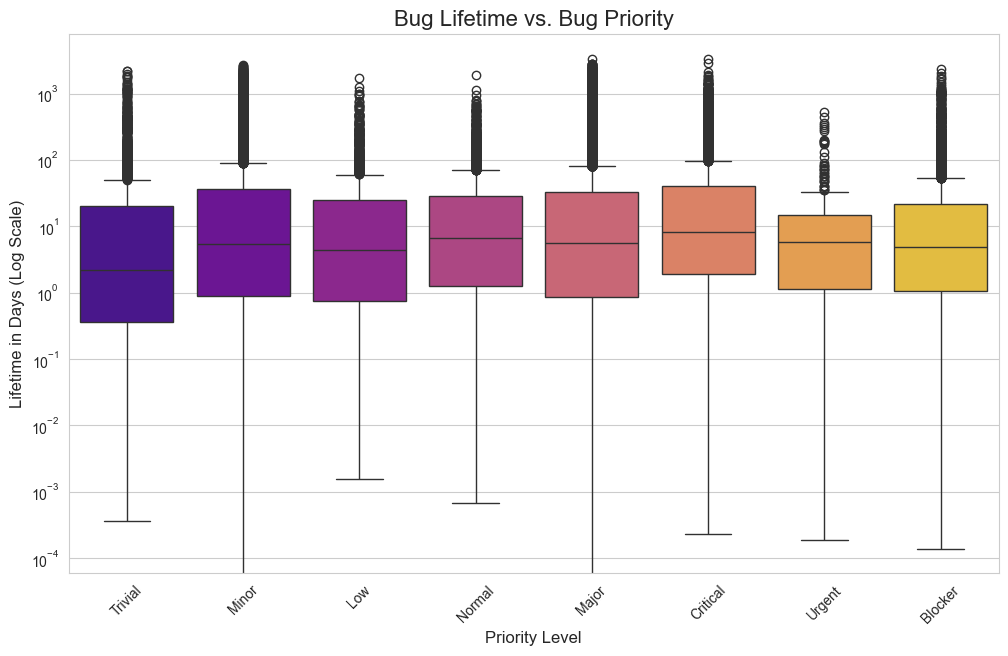

In [24]:
df['CreationDate'] = pd.to_datetime(df['CreationDate'], errors='coerce')
df['ResolutionDate'] = pd.to_datetime(df['ResolutionDate'], errors='coerce')

df['BugLifetime_days'] = (df['ResolutionDate'] - df['CreationDate']).dt.total_seconds() / (60*60*24)

plt.figure(figsize=(12, 7))
sns.boxplot(x='Priority', y='BugLifetime_days', data=df, order=priority_order, palette='plasma')
plt.yscale('log')
plt.title('Bug Lifetime vs. Bug Priority', fontsize=16)
plt.ylabel('Lifetime in Days (Log Scale)', fontsize=12)
plt.xlabel('Priority Level', fontsize=12)
plt.xticks(rotation=45)
plt.show()


--- Finding Initial Key Factors ---


C:\Users\Coral\AppData\Local\Temp\ipykernel_8500\2015108467.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')


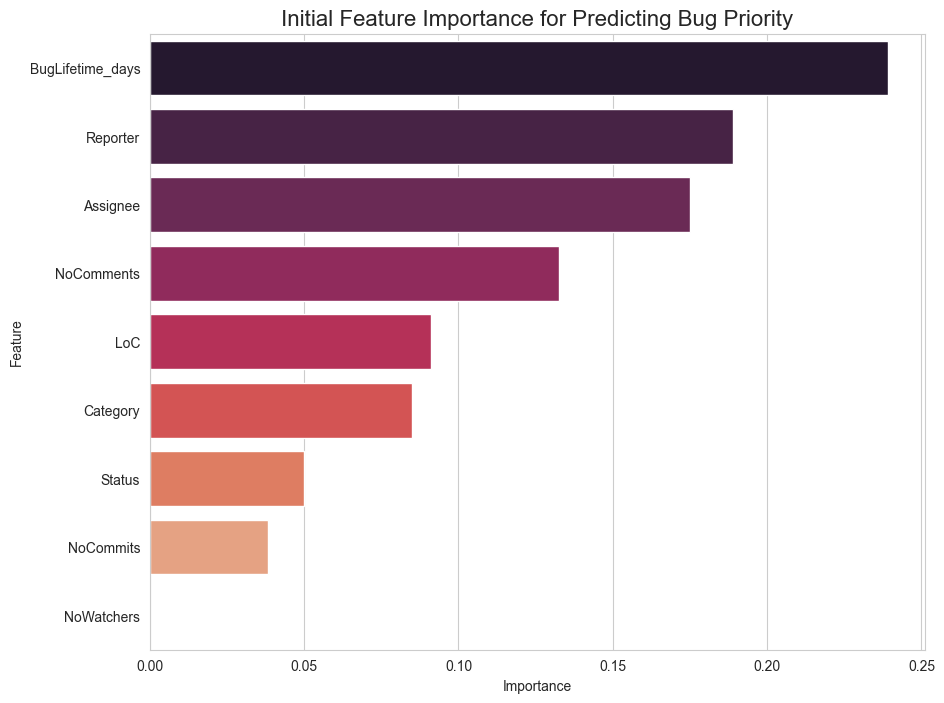


--- Top 5 Most Important Features ---
            Feature  Importance
4  BugLifetime_days    0.239183
7          Reporter    0.189008
8          Assignee    0.175112
0        NoComments    0.132682
2               LoC    0.090981


In [25]:
print("\n--- Finding Initial Key Factors ---")

df_model = df.copy()

features_for_importance = [
    'NoComments', 'NoWatchers', 'LoC', 'NoCommits', 'BugLifetime_days',
    'Category', 'Status', 'Reporter', 'Assignee'
]
target = 'Priority'

df_model = df_model[features_for_importance + [target]].dropna()

for col in ['Category', 'Status', 'Reporter', 'Assignee']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

X = df_model[features_for_importance]
y = df_model[target]

forest = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
forest.fit(X, y)

importances = forest.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features_for_importance, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')
plt.title('Initial Feature Importance for Predicting Bug Priority', fontsize=16)
plt.show()

print("\n--- Top 5 Most Important Features ---")
print(feature_importance_df.head())

## The Initial Baseline (The 8-Class Model)

In [23]:
# --- Imports and Configuration ---
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight

class HuggingFaceLayer(tf.keras.layers.Layer):
    """
    A custom wrapper to fix known incompatibility issues between certain
    versions of Transformers and Keras/TensorFlow.
    """
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def call(self, inputs):
        output = self.model(input_ids=inputs[0], attention_mask=inputs[1])
        return output.last_hidden_state

# --- Data Loading and Feature Engineering ---
def load_and_engineer_features(file_path='promise19_dataset.csv'):
    """Loads data and performs all feature engineering steps."""
    print("--- Loading Data & Engineering Features ---")
    df = pd.read_csv(file_path)

    priority_mapping = {'Trivial': 0, 'Minor': 1, 'Low': 2, 'Normal': 3, 'Major': 4, 'Critical': 5, 'Urgent': 6, 'Blocker': 7}
    df['Priority_encoded'] = df['Priority'].map(priority_mapping)
    df.dropna(subset=['Priority_encoded'], inplace=True)
    df['Priority_encoded'] = df['Priority_encoded'].astype(int)
    
    text_cols = ['SummaryTopWords', 'DescriptionTopWords', 'CommentsTopWords']
    df[text_cols] = df[text_cols].astype(str).fillna('none')
    df['CombinedText'] = df[text_cols].agg(' '.join, axis=1)

    print("Feature engineering complete.")
    return df, priority_mapping

# --- Model Creation Function ---
def create_hybrid_model(num_classes, tabular_feature_count, model_name, max_length):
    """Builds and compiles the hybrid Transformer neural network."""
    print("--- Building Hybrid Neural Network ---")

    bert_model_original = TFDistilBertModel.from_pretrained(model_name)
    bert_model_original.trainable = True
    bert_layer = HuggingFaceLayer(bert_model_original, name="hugging_face_bert")

    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    transformer_output = bert_layer([input_ids, attention_mask])

    cls_token = transformer_output[:, 0, :]
    text_branch = Dense(64, activation='relu')(cls_token)
    text_branch = Dropout(0.3)(text_branch)

    tabular_input = Input(shape=(tabular_feature_count,), name='tabular_input')
    tabular_branch = Dense(64, activation='relu')(tabular_input)
    tabular_branch = BatchNormalization()(tabular_branch)
    tabular_branch = Dropout(0.3)(tabular_branch)
    tabular_branch = Dense(32, activation='relu')(tabular_branch)

    combined = Concatenate()([text_branch, tabular_branch])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.4)(combined)
    output = Dense(num_classes, activation='softmax', name='output')(combined)

    model = Model(inputs=[input_ids, attention_mask, tabular_input], outputs=output)
    optimizer = Adam(learning_rate=3e-5)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.summary()
    return model

# --- Main Execution Function ---
def main():
    """Main function to run the entire pipeline."""
    print("--- Running in CPU-only mode ---")
    
    MODEL_NAME = 'distilbert-base-uncased'
    MAX_LENGTH = 128
    EPOCHS = 5
    BATCH_SIZE = 16

    df, priority_mapping = load_and_engineer_features()
    
    TARGET = 'Priority_encoded'
    TEXT_FEATURE = 'CombinedText'
    NUMERICAL_FEATURES = ['NoComments', 'NoWatchers', 'NoAttachments', 'LoC']
    CATEGORICAL_FEATURES = ['Category', 'Status', 'Reporter', 'Assignee']

    df[NUMERICAL_FEATURES] = df[NUMERICAL_FEATURES].fillna(df[NUMERICAL_FEATURES].median())
    df[CATEGORICAL_FEATURES] = df[CATEGORICAL_FEATURES].fillna('missing')

    for col in CATEGORICAL_FEATURES:
        df[col] = LabelEncoder().fit_transform(df[col])

    TABULAR_FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES
    
    print("\n--- Splitting and Preprocessing Data ---")
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[TARGET])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[TARGET])

    scaler = StandardScaler()
    X_train_tabular = scaler.fit_transform(train_df[TABULAR_FEATURES])
    X_val_tabular = scaler.transform(val_df[TABULAR_FEATURES])
    X_test_tabular = scaler.transform(test_df[TABULAR_FEATURES])

    tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
    def encode_texts(df_slice):
        return tokenizer(
            df_slice[TEXT_FEATURE].tolist(),
            max_length=MAX_LENGTH,
            truncation=True,
            padding='max_length',
            return_tensors='tf'
        )

    train_encodings = encode_texts(train_df)
    val_encodings = encode_texts(val_df)
    test_encodings = encode_texts(test_df)

    y_train = train_df[TARGET].values
    y_val = val_df[TARGET].values
    y_test = test_df[TARGET].values

    print(f"Data split: {len(y_train)} training, {len(y_val)} validation, {len(y_test)} testing samples.")
    
    hybrid_model = create_hybrid_model(
        num_classes=len(priority_mapping),
        tabular_feature_count=len(TABULAR_FEATURES),
        model_name=MODEL_NAME,
        max_length=MAX_LENGTH
    )
    
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    
    X_train_hybrid = {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'tabular_input': X_train_tabular
    }
    X_val_hybrid = {
        'input_ids': val_encodings['input_ids'],
        'attention_mask': val_encodings['attention_mask'],
        'tabular_input': X_val_tabular
    }
    X_test_hybrid = {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'tabular_input': X_test_tabular
    }

    print("\n--- Training Hybrid Transformer Model ---")
    history = hybrid_model.fit(
        X_train_hybrid,
        y_train,
        validation_data=(X_val_hybrid, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weights_dict
    )

    print("\n--- Hybrid Model Evaluation ---")
    y_prob_hybrid = hybrid_model.predict(X_test_hybrid)
    y_pred_hybrid = np.argmax(y_prob_hybrid, axis=1)

    # --- Save Baseline Model Results ---
    np.save('baseline_y_test.npy', y_test)
    np.save('baseline_y_pred_proba.npy', y_prob_hybrid)
    print("\nBaseline model results saved to files.")


    print(classification_report(y_test, y_pred_hybrid, target_names=priority_mapping.keys()))
    weighted_f1 = f1_score(y_test, y_pred_hybrid, average='weighted')
    print(f"\nWeighted F1-Score (Primary Metric): {weighted_f1:.4f}")

# --- Script Entry Point ---
if __name__ == "__main__":
    main()


--- Running in CPU-only mode ---
--- Loading Data & Engineering Features ---
Feature engineering complete.

--- Splitting and Preprocessing Data ---
Data split: 51304 training, 10994 validation, 10994 testing samples.
--- Building Hybrid Neural Network ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hugging_face_bert   │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│ (HuggingFaceLayer)  │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │        576 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 768)       │          0 │ hugging_face_ber… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │     49,216 │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      2,080 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96)        │          0 │ dropout_12[0][0], │
│ (Concatenate)       │                   │            │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      6,208 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 8)         │        520 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,856 (229.91 KB)

 Trainable params: 58,728 (229.41 KB)

 Non-trainable params: 128 (512.00 B)


--- Training Hybrid Transformer Model ---
Epoch 1/5
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 1916s 596ms/step - accuracy: 0.1444 - loss: 2.1823 - val_accuracy: 0.1378 - val_loss: 2.0257
Epoch 2/5
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 2080s 649ms/step - accuracy: 0.1461 - loss: 2.0261 - val_accuracy: 0.0979 - val_loss: 2.0195
Epoch 3/5
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 2058s 642ms/step - accuracy: 0.1564 - loss: 1.9321 - val_accuracy: 0.1119 - val_loss: 1.9455
Epoch 4/5
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 2124s 662ms/step - accuracy: 0.1729 - loss: 1.8779 - val_accuracy: 0.1272 - val_loss: 1.9048
Epoch 5/5
3207/3207 ━━━━━━━━━━━━━━━━━━━━ 1976s 616ms/step - accuracy: 0.1795 - loss: 1.7815 - val_accuracy: 0.1187 - val_loss: 1.8868

--- Hybrid Model Evaluation ---
344/344 ━━━━━━━━━━━━━━━━━━━━ 285s 827ms/step

Baseline model results saved to files.
              precision    recall  f1-score   support

     Trivial       0.05      0.38      0.09       352
       Minor       0.18      0.22      0.20      1706
      

## The Best Model (The Fine-Tuned Ensemble)

In [26]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

class HuggingFaceLayer(tf.keras.layers.Layer):
    """A custom wrapper to fix library incompatibility."""
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def call(self, inputs):
        output = self.model(input_ids=inputs[0], attention_mask=inputs[1])
        return output.last_hidden_state

# --- 1. Data Loading and Feature Engineering ---
def load_and_engineer_features(file_path='promise19_dataset.csv'):
    print("--- Loading Data & Engineering Features ---")
    df = pd.read_csv(file_path)
    print("Available columns are:", df.columns.tolist()) # Confirming columns
    
    priority_mapping = {
        'Trivial': 0, 'Minor': 0, 'Low': 0, 'Normal': 1, 'Major': 1,
        'Critical': 2, 'Urgent': 2, 'Blocker': 2
    }
    df['Priority_encoded'] = df['Priority'].map(priority_mapping)
    df.dropna(subset=['Priority_encoded'], inplace=True)
    df['Priority_encoded'] = df['Priority_encoded'].astype(int)
    
    text_cols = ['SummaryTopWords', 'DescriptionTopWords', 'CommentsTopWords']
    
    df[text_cols] = df[text_cols].astype(str).fillna('none')
    df['CombinedText'] = df[text_cols].agg(' '.join, axis=1)

    return df

df = load_and_engineer_features()
TARGET = 'Priority_encoded'
TEXT_FEATURE = 'CombinedText'
NUMERICAL_FEATURES = ['NoComments', 'NoWatchers', 'NoAttachments', 'LoC']
CATEGORICAL_FEATURES = ['Category', 'Status', 'Reporter', 'Assignee']
df[NUMERICAL_FEATURES] = df[NUMERICAL_FEATURES].fillna(df[NUMERICAL_FEATURES].median())
df[CATEGORICAL_FEATURES] = df[CATEGORICAL_FEATURES].fillna('missing')
for col in CATEGORICAL_FEATURES:
    df[col] = LabelEncoder().fit_transform(df[col])
TABULAR_FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES

# --- 2. Data Splitting ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[TARGET])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[TARGET])

# --- 3. Preprocessing for Tabular Data ---
scaler = StandardScaler()
X_train_tabular = scaler.fit_transform(train_df[TABULAR_FEATURES])
X_val_tabular = scaler.transform(val_df[TABULAR_FEATURES])
X_test_tabular = scaler.transform(test_df[TABULAR_FEATURES])
y_train = train_df[TARGET].values
y_val = val_df[TARGET].values
y_test = test_df[TARGET].values

# --- 4. Train the LightGBM Model ---
print("\n--- Training LightGBM Model ---")
smote = SMOTE(random_state=42)
X_train_tabular_resampled, y_train_resampled = smote.fit_resample(X_train_tabular, y_train)
lgbm_model = lgb.LGBMClassifier(objective='multiclass', random_state=42, n_jobs=-1)
lgbm_model.fit(X_train_tabular_resampled, y_train_resampled)
lgbm_val_preds = lgbm_model.predict_proba(X_val_tabular)
lgbm_test_preds = lgbm_model.predict_proba(X_test_tabular)

# --- 5. Fine-Tune the Hybrid Transformer Model ---
print("\n--- Preparing to Fine-Tune Transformer Model ---")
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 128
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
def encode_texts(df_slice):
    return tokenizer(df_slice[TEXT_FEATURE].tolist(), max_length=MAX_LENGTH, truncation=True, padding='max_length', return_tensors='tf')

train_encodings = encode_texts(train_df)
val_encodings = encode_texts(val_df)
test_encodings = encode_texts(test_df)

# --- Corrected Model Creation Function ---
def create_hybrid_model(num_classes, tabular_feature_count):
    # Load the original model
    bert_model_original = TFDistilBertModel.from_pretrained(MODEL_NAME)
    bert_model_original.trainable = True

    # Wrap it in our custom layer
    bert_layer = HuggingFaceLayer(bert_model_original, name="hugging_face_bert")

    # Define model inputs
    input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask')
    
    # Call the wrapper (which now returns the correct tensor)
    transformer_output = bert_layer([input_ids, attention_mask])
    
    # The rest of the model architecture
    cls_token = transformer_output[:, 0, :]
    text_branch = Dense(64, activation='relu')(cls_token)
    text_branch = Dropout(0.3)(text_branch)

    tabular_input = Input(shape=(tabular_feature_count,), name='tabular_input')
    tabular_branch = Dense(64, activation='relu')(tabular_input)
    tabular_branch = BatchNormalization()(tabular_branch)
    tabular_branch = Dropout(0.3)(tabular_branch)
    tabular_branch = Dense(32, activation='relu')(tabular_branch)

    combined = Concatenate()([text_branch, tabular_branch])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.4)(combined)
    output = Dense(num_classes, activation='softmax', name='output')(combined)

    model = Model(inputs=[input_ids, attention_mask, tabular_input], outputs=output)
    optimizer = Adam(learning_rate=3e-5)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

hybrid_model = create_hybrid_model(num_classes=3, tabular_feature_count=len(TABULAR_FEATURES))
X_train_hybrid = {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'tabular_input': X_train_tabular}
X_val_hybrid = {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'tabular_input': X_val_tabular}

print("\n--- Starting Fine-Tuning ---")
hybrid_model.fit(
    X_train_hybrid, y_train,
    validation_data=(X_val_hybrid, y_val),
    epochs=3, 
    batch_size=8,
    callbacks=[EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)]
)
transformer_val_preds = hybrid_model.predict(X_val_hybrid)
transformer_test_preds = hybrid_model.predict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'tabular_input': X_test_tabular})

# --- 6. Ensemble the Models ---
print("\n--- Building and Training Ensemble Model ---")
X_val_ensemble = np.concatenate([lgbm_val_preds, transformer_val_preds], axis=1)
X_test_ensemble = np.concatenate([lgbm_test_preds, transformer_test_preds], axis=1)

ensemble_model = LogisticRegression(random_state=42)
ensemble_model.fit(X_val_ensemble, y_val)

# --- 7. Final Evaluation ---
print("\n--- Final Ensemble Model Evaluation ---")
ensemble_preds = ensemble_model.predict(X_test_ensemble)

report_labels = ['Low Severity', 'Medium Severity', 'High Severity']
print(classification_report(y_test, ensemble_preds, target_names=report_labels))
weighted_f1 = f1_score(y_test, ensemble_preds, average='weighted')
print(f"\nFinal Ensemble Weighted F1-Score: {weighted_f1:.4f}")

--- Loading Data & Engineering Features ---
Available columns are: ['Project', 'Owner', 'Manager', 'Category', 'Key', 'Priority', 'Status', 'Reporter', 'Assignee', 'Components', 'SummaryTopWords', 'DescriptionTopWords', 'CommentsTopWords', 'CreationDate', 'ResolutionDate', 'AffectsVersions', 'FixVersions', 'NoComments', 'FirstCommentDate', 'LastCommentDate', 'NoWatchers', 'NoAttachments', 'FirstAttachmentDate', 'LastAttachmentDate', 'NoAttachedPatches', 'FirstAttachedPatchDate', 'LastAttachedPatchDate', 'InwardIssueLinks', 'OutwardIssueLinks', 'HasMergeCommit', 'CommitsMessagesTopWords', 'NoCommits', 'NoAuthors', 'NoCommitters', 'AuthorsFirstCommitDate', 'AuthorsLastCommitDate', 'CommittersFirstCommitDate', 'CommittersLastCommitDate', 'NonSrcAddFiles', 'NonSrcDelFiles', 'NonSrcModFiles', 'NonSrcAddLines', 'NonSrcDelLines', 'SrcAddFiles', 'SrcDelFiles', 'SrcModFiles', 'SrcAddLines', 'SrcDelLines', 'TestAddFiles', 'TestDelFiles', 'TestModFiles', 'TestAddLines', 'TestDelLines', 'LoC', 'Fi

C:\Users\Coral\.conda\envs\tf-cpu\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Coral\.conda\envs\tf-cpu\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Preparing to Fine-Tune Transformer Model ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.



--- Starting Fine-Tuning ---
Epoch 1/3
1340/5864 ━━━━━━━━━━━━━━━━━━━━ 28:45 381ms/step - accuracy: 0.5568 - loss: 1.0326

KeyboardInterrupt: 

In [27]:
# --- Save Champion Model Results ---
np.save('champion_y_test.npy', y_test)
np.save('champion_y_pred_proba.npy', ensemble_model.predict_proba(X_test_ensemble))
print("\nChampion model results saved to files.")


Champion model results saved to files.


## The Balanced Model (The One-vs-Rest Ensemble)

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE

class HuggingFaceLayer(tf.keras.layers.Layer):
    """A custom wrapper to fix library incompatibility."""
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def call(self, inputs):
        output = self.model(input_ids=inputs[0], attention_mask=inputs[1])
        return output.last_hidden_state

# --- 1. Data Loading and Feature Engineering ---
def load_and_engineer_features(file_path='promise19_dataset.csv'):
    print("--- Loading Data & Engineering Features for OvR ---")
    df = pd.read_csv(file_path)
    priority_mapping = {
        'Trivial': 0, 'Minor': 0, 'Low': 0, 'Normal': 1, 'Major': 1,
        'Critical': 2, 'Urgent': 2, 'Blocker': 2
    }
    df['Priority_encoded'] = df['Priority'].map(priority_mapping)
    df.dropna(subset=['Priority_encoded'], inplace=True)
    df['Priority_encoded'] = df['Priority_encoded'].astype(int)
    
    text_cols = ['SummaryTopWords', 'DescriptionTopWords', 'CommentsTopWords']
    df[text_cols] = df[text_cols].astype(str).fillna('none')
    df['CombinedText'] = df[text_cols].agg(' '.join, axis=1)
    
    print("--- Creating One-vs-Rest target columns ---")
    df['is_low'] = (df['Priority_encoded'] == 0).astype(int)
    df['is_medium'] = (df['Priority_encoded'] == 1).astype(int)
    df['is_high'] = (df['Priority_encoded'] == 2).astype(int)
    
    return df

df = load_and_engineer_features()
TEXT_FEATURE = 'CombinedText'
NUMERICAL_FEATURES = ['NoComments', 'NoWatchers', 'NoAttachments', 'LoC']
CATEGORICAL_FEATURES = ['Category', 'Status', 'Reporter', 'Assignee']
df[NUMERICAL_FEATURES] = df[NUMERICAL_FEATURES].fillna(df[NUMERICAL_FEATURES].median())
df[CATEGORICAL_FEATURES] = df[CATEGORICAL_FEATURES].fillna('missing')
for col in CATEGORICAL_FEATURES:
    df[col] = LabelEncoder().fit_transform(df[col])
TABULAR_FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES

# --- 2. Data Splitting & Preprocessing ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Priority_encoded'])
scaler = StandardScaler()
X_train_tabular = scaler.fit_transform(train_df[TABULAR_FEATURES])
X_test_tabular = scaler.transform(test_df[TABULAR_FEATURES])
y_test_original = test_df['Priority_encoded'].values

# --- 3. Text Feature Extraction (using RoBERTa) ---
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 128
print(f"\n--- Initializing Tokenizer: {MODEL_NAME} ---")
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
def encode_texts(df_slice):
    # Ensure this returns a dictionary-like object that can be converted to numpy arrays
    return tokenizer(df_slice[TEXT_FEATURE].tolist(), max_length=MAX_LENGTH, truncation=True, padding='max_length')

train_encodings = encode_texts(train_df)
test_encodings = encode_texts(test_df)

print("\n--- Extracting Text Features with RoBERTa (this may take a while) ---")
with tf.device('/CPU:0'):
    # 1. Load the original RoBERTa model
    roberta_model_original = TFRobertaModel.from_pretrained(MODEL_NAME)
    
    roberta_layer = HuggingFaceLayer(roberta_model_original)

    input_ids_layer = Input(shape=(MAX_LENGTH,), dtype=tf.int32)
    attention_mask_layer = Input(shape=(MAX_LENGTH,), dtype=tf.int32)
    
    embedding_layer = roberta_layer([input_ids_layer, attention_mask_layer])
    
    cls_token_embedding = embedding_layer[:, 0, :]
    feature_extractor = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=cls_token_embedding)
    
    X_train_text = feature_extractor.predict([np.array(train_encodings['input_ids']), np.array(train_encodings['attention_mask'])])
    X_test_text = feature_extractor.predict([np.array(test_encodings['input_ids']), np.array(test_encodings['attention_mask'])])

# --- 4. Combine Features ---
X_train_combined = np.concatenate([X_train_tabular, X_train_text], axis=1)
X_test_combined = np.concatenate([X_test_tabular, X_test_text], axis=1)

# --- 5. Train the OvR Models ---
ovr_models = {}
class_names = ['low', 'medium', 'high']
report_labels = ['Low Severity', 'Medium Severity', 'High Severity']
final_test_predictions_proba = []

for i, class_name in enumerate(class_names):
    print(f"\n--- Training Binary Model for Class: {report_labels[i]} ---")
    
    # Prepare the binary target variable for this model
    y_train_ovr = train_df[f'is_{class_name}'].values
    
    # Balance data for this specific binary problem
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train_ovr)
    
    # Train a single LGBM on the full combined and balanced feature set
    ovr_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
    ovr_model.fit(X_train_resampled, y_train_resampled)
    
    # Get probability of the "Yes" class (class 1) for the test set
    class_probs = ovr_model.predict_proba(X_test_combined)[:, 1]
    final_test_predictions_proba.append(class_probs)

# --- 6. Final Evaluation ---
print("\n--- Final OvR Ensemble Model Evaluation ---")
# Combine the probabilities from each binary model into one array
final_probabilities = np.vstack(final_test_predictions_proba).T

# The final prediction is the class with the highest probability
final_predictions = np.argmax(final_probabilities, axis=1)

print(classification_report(y_test_original, final_predictions, target_names=report_labels))
weighted_f1 = f1_score(y_test_original, final_predictions, average='weighted')
print(f"\nFinal OvR Weighted F1-Score: {weighted_f1:.4f}")

In [28]:
# --- Save Balanced (OvR) Model Results ---
np.save('ovr_y_test.npy', y_test_original)
np.save('ovr_y_pred_proba.npy', final_probabilities)
print("\nBalanced (OvR) model results saved to files.")


Balanced (OvR) model results saved to files.


## ROC

--- Baseline Model Analysis (8-Class) ---


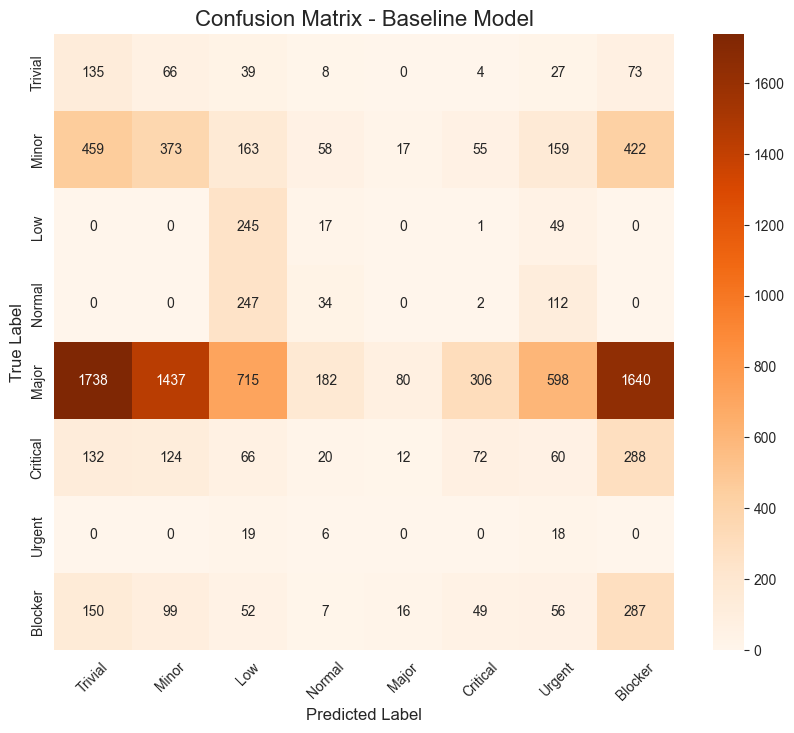

C:\Users\Coral\AppData\Local\Temp\ipykernel_20900\846717530.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_classes)


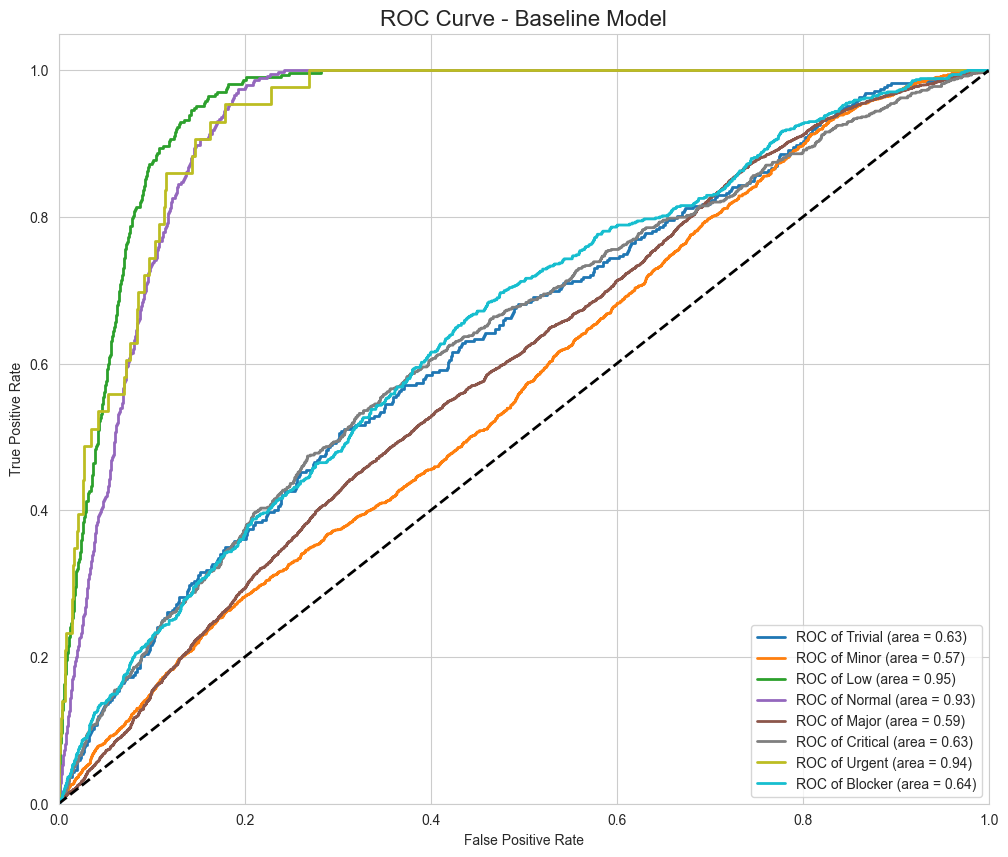



--- Champion Model Analysis ---


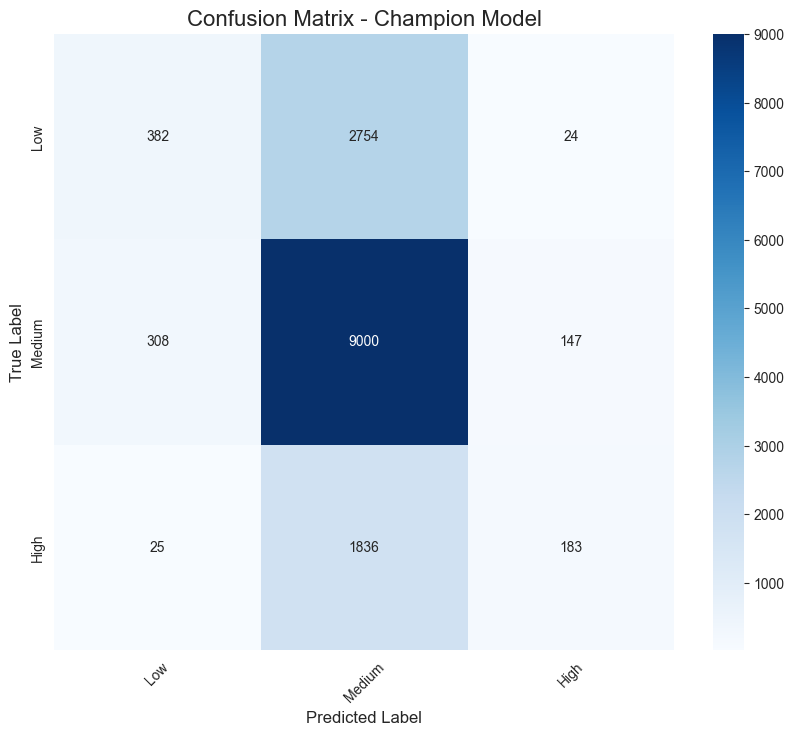

C:\Users\Coral\AppData\Local\Temp\ipykernel_20900\846717530.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_classes)


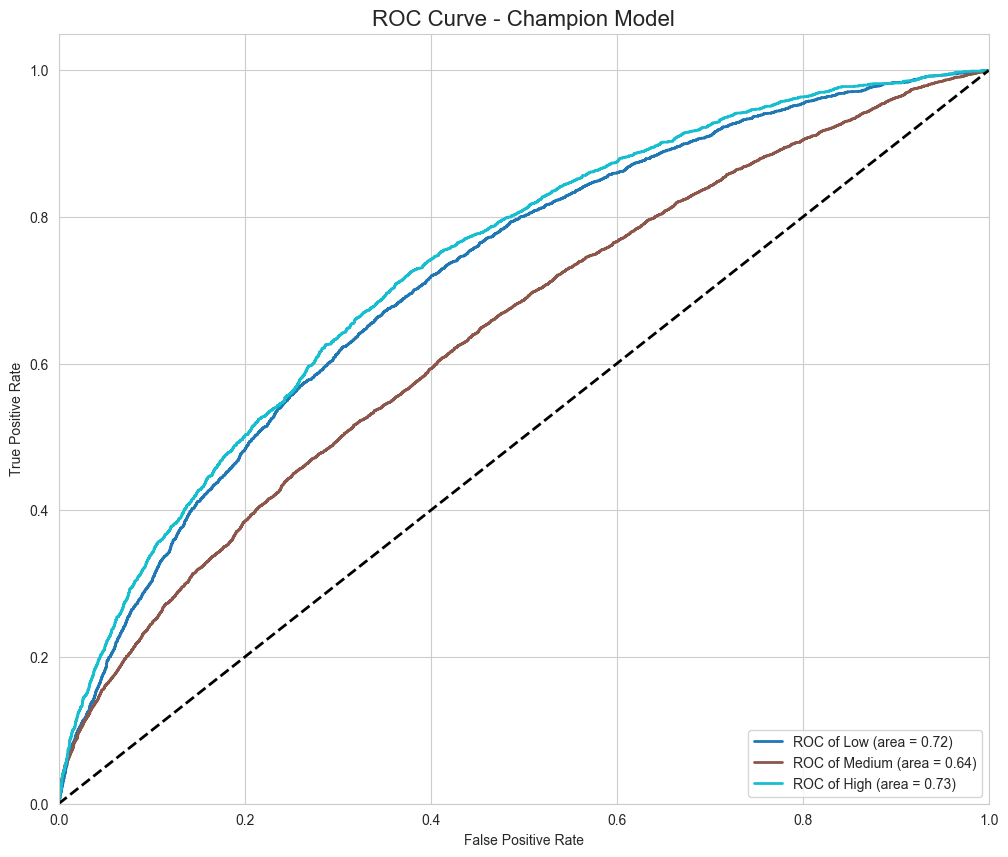



--- Balanced (OvR) Model Analysis ---


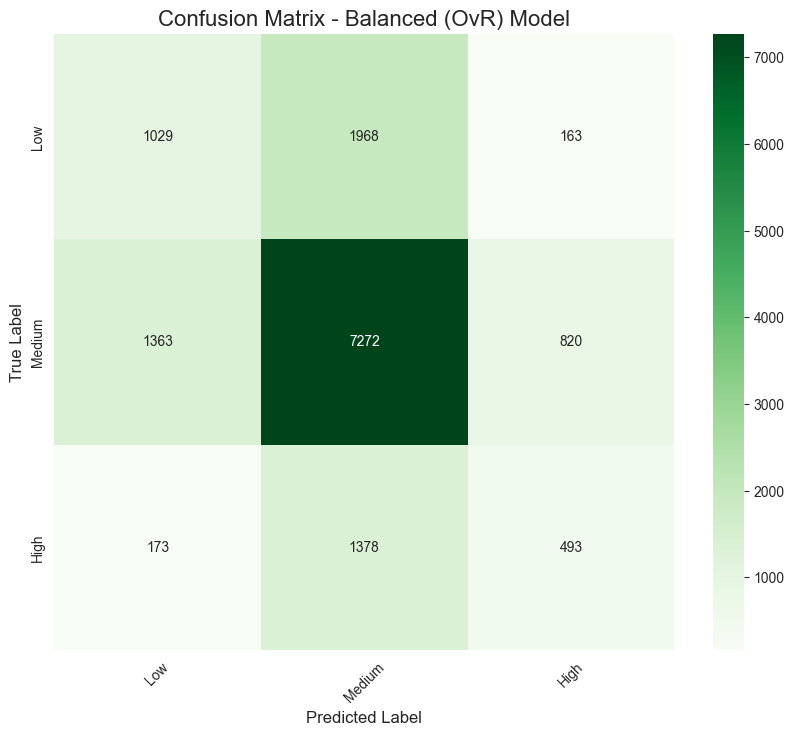

C:\Users\Coral\AppData\Local\Temp\ipykernel_20900\846717530.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_classes)


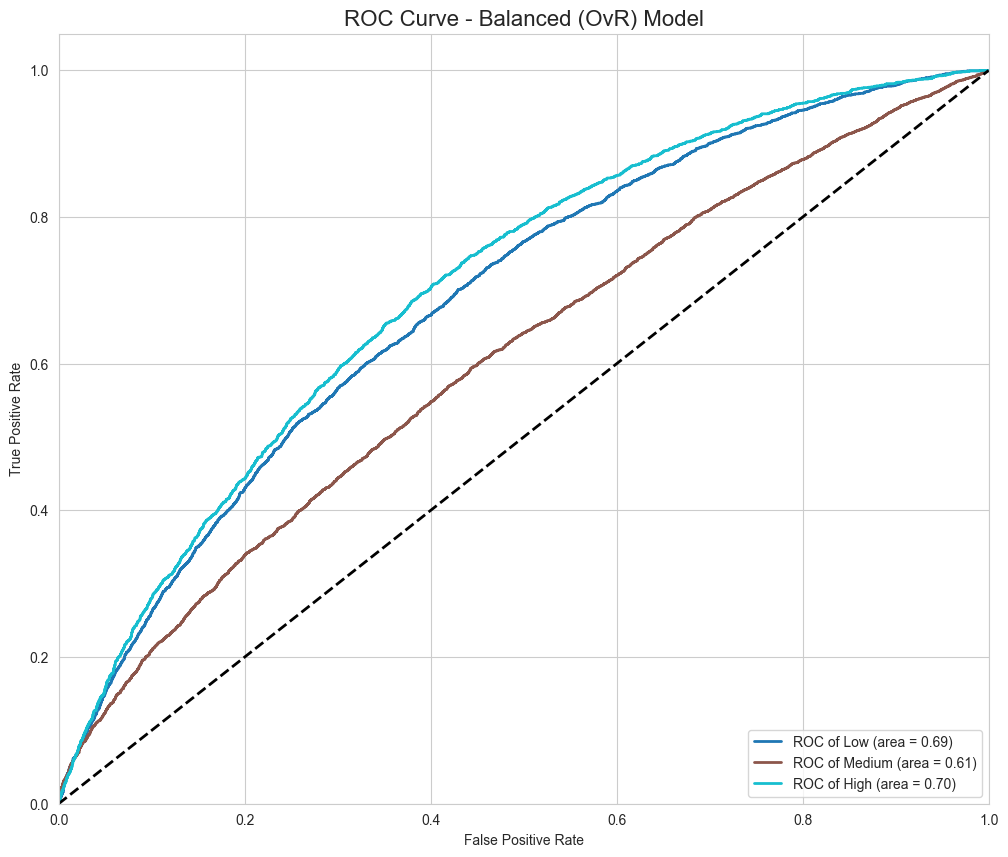

In [29]:
# FINAL_PLOTTING_NOTEBOOK.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Set plot style
sns.set_style("whitegrid")

# --- Function to Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred_classes, title, cmap, class_labels):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

# --- CORRECTED Function to Plot ROC Curves ---
def plot_roc_auc(y_true, y_prob, title, class_labels):
    y_true_binarized = label_binarize(y_true, classes=range(len(class_labels)))
    n_classes = y_true_binarized.shape[1]
    
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(12, 10))
    # Get the colormap object
    cmap = plt.cm.get_cmap('tab10', n_classes) 
    # Loop through the number of classes and get a color for each
    for i in range(n_classes):
        color = cmap(i)
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC of {class_labels[i]} (area = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

# --- Analysis for the Baseline Model ---
print("--- Baseline Model Analysis (8-Class) ---")
y_test_base = np.load('baseline_y_test.npy')
y_prob_base = np.load('baseline_y_pred_proba.npy')
y_pred_base = np.argmax(y_prob_base, axis=1)
base_labels = ['Trivial', 'Minor', 'Low', 'Normal', 'Major', 'Critical', 'Urgent', 'Blocker']

plot_confusion_matrix(y_test_base, y_pred_base, 'Confusion Matrix - Baseline Model', 'Oranges', base_labels)
plot_roc_auc(y_test_base, y_prob_base, 'ROC Curve - Baseline Model', base_labels)


# --- Analysis for the Champion Model ---
print("\n\n--- Champion Model Analysis ---")
y_test_champion = np.load('champion_y_test.npy')
y_prob_champion = np.load('champion_y_pred_proba.npy')
y_pred_champion = np.argmax(y_prob_champion, axis=1)
report_labels_3_class = ['Low', 'Medium', 'High']

plot_confusion_matrix(y_test_champion, y_pred_champion, 'Confusion Matrix - Champion Model', 'Blues', report_labels_3_class)
plot_roc_auc(y_test_champion, y_prob_champion, 'ROC Curve - Champion Model', report_labels_3_class)


# --- Analysis for the Balanced (OvR) Model ---
print("\n\n--- Balanced (OvR) Model Analysis ---")
y_test_ovr = np.load('ovr_y_test.npy')
y_prob_ovr = np.load('ovr_y_pred_proba.npy')
y_pred_ovr = np.argmax(y_prob_ovr, axis=1)

plot_confusion_matrix(y_test_ovr, y_pred_ovr, 'Confusion Matrix - Balanced (OvR) Model', 'Greens', report_labels_3_class)
plot_roc_auc(y_test_ovr, y_prob_ovr, 'ROC Curve - Balanced (OvR) Model', report_labels_3_class)